
Training LogisticRegression...


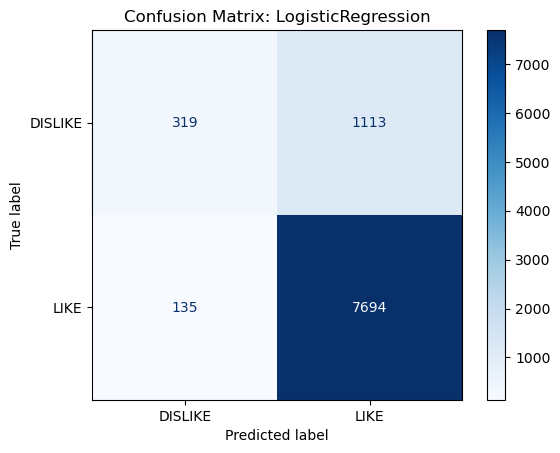


Training RandomForest...


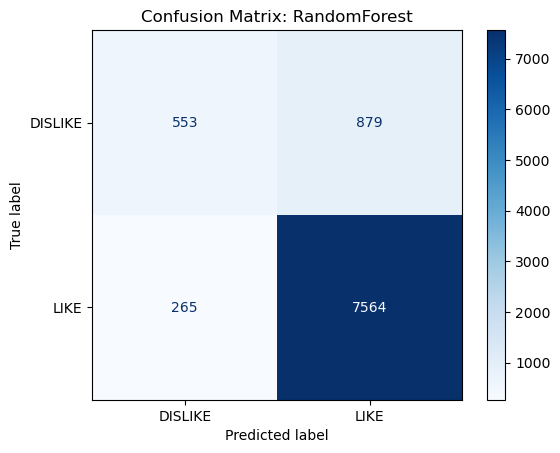


Training GaussianNB...


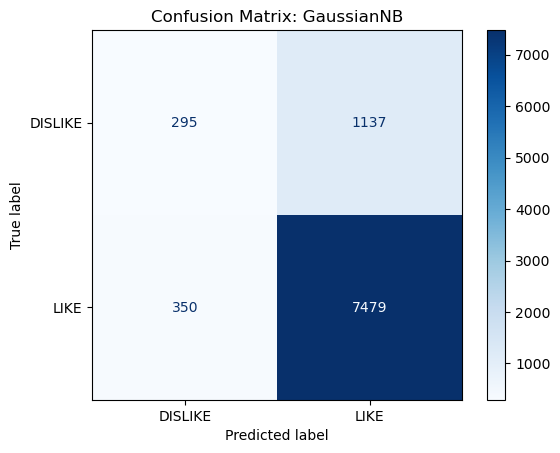

Model Evaluation Results:
                Model                                        Best Params  \
0  LogisticRegression  {'model__C': 1, 'model__penalty': 'l2', 'model...   
1        RandomForest  {'model__max_depth': None, 'model__n_estimator...   
2          GaussianNB                                                 {}   

   CV Precision  CV Recall  CV F1  Test Precision  Test Recall  Test F1  \
0          0.87       0.98   0.92            0.87         0.98     0.92   
1          0.90       0.96   0.93            0.90         0.97     0.93   
2          0.87       0.96   0.91            0.87         0.96     0.91   

   Test Accuracy  
0           0.87  
1           0.88  
2           0.84  


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score,
    classification_report, make_scorer
)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Reload dataset
df = pd.read_csv('text_features_full.csv')
df = df.sample(n=50000, random_state=42)
# Filter out neutral reviews (Score == 3)
df = df[df['Score'] != 3]
# Assign binary labels: 1 = positive (>3), 0 = negative (<3)
df['Label'] = df['Score'].apply(lambda x: 1 if x > 3 else 0)

# Feature selection
features = [
    'SentimentText_Polarity',
    'SentimentText_Subjectivity',
    'TextLengthWords',
    'NumUppercaseWords',
    'AvgWordLength'
]
X = df[features]
y = df['Label']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Define scoring metrics
scoring = {
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

# Models and hyperparameter grids, now including GaussianNB
models = {
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=1000),
        'params': {
            'model__C': [0.01, 0.1, 1, 10],
            'model__penalty': ['l2'],
            'model__solver': ['lbfgs']
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(),
        'params': {
            'model__n_estimators': [50, 100],
            'model__max_depth': [5, 10, None]
        }
    },
    'GaussianNB': {
        'model': GaussianNB(),
        'params': {
            # GaussianNB has no mandatory hyperparameters
            # you can optionally tune 'var_smoothing' if desired:
            # 'model__var_smoothing': [1e-9, 1e-8, 1e-7]
        }
    }
}

# Evaluate models
results = []
for name, cfg in models.items():
    print(f"\nTraining {name}...")
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', cfg['model'])
    ])
    grid = GridSearchCV(pipe, cfg['params'], scoring='f1', cv=5, n_jobs=-1)
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_

    # Internal 5-fold CV
    precision = cross_val_score(
        best_model, X_train, y_train, cv=5, scoring='precision'
    ).mean()
    recall = cross_val_score(
        best_model, X_train, y_train, cv=5, scoring='recall'
    ).mean()
    f1 = cross_val_score(
        best_model, X_train, y_train, cv=5, scoring='f1'
    ).mean()

    # Test set evaluation
    y_test_pred = best_model.predict(X_test)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    test_report = classification_report(
        y_test, y_test_pred, target_names=['DISLIKE', 'LIKE']
    )

    #confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['DISLIKE', 'LIKE'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix: {name}")
    plt.show()

    results.append({
        'Model': name,
        'Best Params': grid.best_params_,
        'CV Precision': round(precision, 2),
        'CV Recall': round(recall, 2),
        'CV F1': round(f1, 2),
        'Test Precision': round(test_precision, 2),
        'Test Recall': round(test_recall, 2),
        'Test F1': round(test_f1, 2),
        'Test Accuracy': round(test_acc, 2),
        'Classification Report': test_report
    })

# Show results
results_df = pd.DataFrame(results)
print("Model Evaluation Results:")
print(results_df[['Model',
                  'Best Params',
                  'CV Precision',
                  'CV Recall',
                  'CV F1',
                  'Test Precision',
                  'Test Recall',
                  'Test F1',
                  'Test Accuracy']])